# Server dependent exponential distribution

### How it was implemented
- Implement/allow server-dependent services in `ciw`
- Create a class that inherits from `ciw.dists.Distriution`
- Write a new `__init__` method and a new `sample` method  

In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
class ServerDependentExponential(ciw.dists.Exponential):
    def __init__(self, rates):
        self.rates = rates

    def sample(self, t=None, ind=None):
        n = ind.server.id_number
        r = self.rates[ind.server.id_number]

        # Adding an additional attribute to the server object
        if hasattr(ind.server, "served_inds"):
            ind.server.served_inds.append(self.simulation.current_time)
        else:
            ind.server.served_inds = [self.simulation.current_time]

        return random.expovariate(r)

In [8]:
# Server 1 has a rate of 1, server 2 has a rate of 2, etc.
rates = {
    1: 1, 
    2: 2,
    3: 3,
    4: 4,
}
N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=10)],
    service_distributions=[ServerDependentExponential(rates=rates)],
    number_of_servers=[4]
)
ciw.seed(0)
Q = ciw.Simulation(N)
Q.simulate_until_max_time(500)

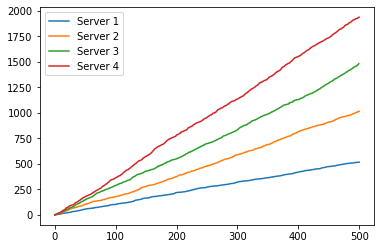

In [9]:
for s in Q.nodes[1].servers:
    plt.plot(
        [0] + [t for t in s.served_inds],
        [0] + [i + 1 for i, _ in enumerate(s.served_inds)],
    label=f"Server {s.id_number}") 
    plt.legend()

## Emergency Department application

In [10]:
import numpy as np
import networkx as nx
import ambulance_game as abg

### Parameters

In [11]:
lambda_1 = 1
lambda_2 = 0.25
mu = 0.5
num_of_servers = 3
threshold = 4
system_capacity = 10
buffer_capacity = 5

runtime = 1000
seed_num = 0

### Markov model

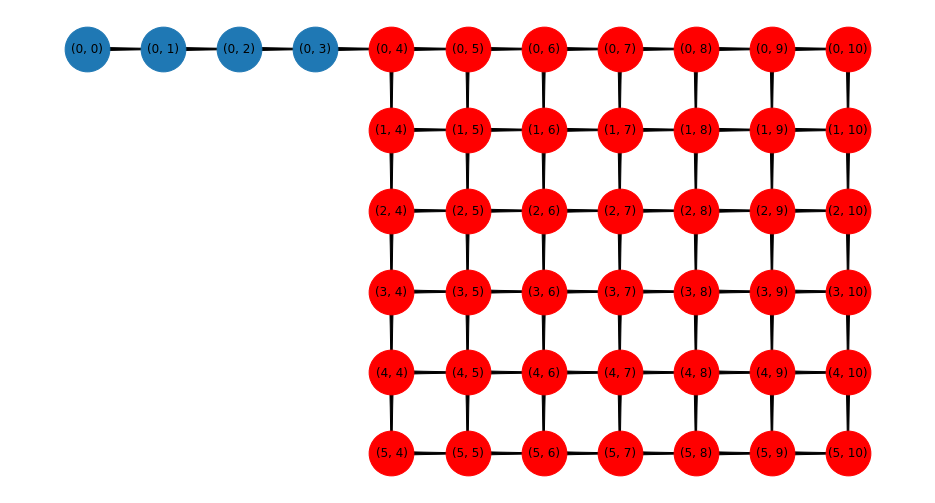

In [228]:
G = abg.markov.visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

### Normal simualtion VS simulation with server dependent distributions

In [12]:
mu = 0.5

In [13]:
Q = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
)

In [16]:
Q_server_dep = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    # mu={1: mu, 2: mu, 3: mu},
    mu={1: mu, 2: 2*mu, 3: 3*mu},
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
)

### Waiting time

In [17]:
wait = np.mean([w.waiting_time for w in Q.get_all_records()])
wait_server_dep = np.mean([w.waiting_time for w in Q_server_dep.get_all_records()])

print(f"Mean waiting time (normal simulation): {wait}")
print(f"Mean waiting time (server dependent) : {wait_server_dep}")

Mean waiting time (normal simulation): 0.8911109881942515
Mean waiting time (server dependent) : 0.05976174283249828


### Server busy time

In [18]:
all_times = [s.busy_time for s in Q.nodes[2].servers]
all_times_server_dep = [s.busy_time for s in Q_server_dep.nodes[2].servers]

print("\t\t\t Servers busy times")
print("         - Normal simulation -     - Server dependent simulation -")
for i, (s, s_server_dep) in enumerate(zip(all_times, all_times_server_dep)):
    print(f"Server {i+1}:  {round(s, 12)},            {round(s_server_dep, 12)}")

			 Servers busy times
         - Normal simulation -     - Server dependent simulation -
Server 1:  864.886057221312,            701.315447594087
Server 2:  811.272570299045,            448.768659686933
Server 3:  761.569296958248,            238.704501503963


### Note:
Source code for `ambulance_game` decides which distribution to use based on the type of `mu`:
- `float`/`int`
- `dict` with keys as `tuples` and values as `float`/`int`
- `dict` with keys as `int` and values as `float`/`int`
- `dict` with keys as `int` and values as: 
   - `dict` with keys `tuples` and values `float`/`int`

# Fair Allocation

- Implemented server priorities in `ciw`
- Create a function that will serve as a `server_priority` function
- Write a new `__init__` method and a new `sample` method  

In [218]:
def busy_time(srv, ind):
    return srv.busy_time

def served_individuals(srv, ind):
    if hasattr(srv, "served_inds"):
        return len(srv.served_inds)
    return 0

In [219]:
rates = {1: 1, 2: 1, 3: 1, 4: 1}
N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=1)],
    service_distributions=[ServerDependentExponential(rates=rates)],
    number_of_servers=[4],
    # server_priority_functions=[busy_time],
)
ciw.seed(0)
Q = ciw.Simulation(N)
Q.simulate_until_max_time(500)

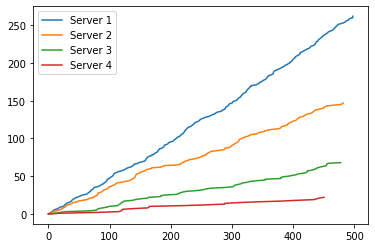

In [221]:
for s in Q.nodes[1].servers:
    plt.plot(
        [0] + [t for t in s.served_inds],
        [0] + [i + 1 for i, _ in enumerate(s.served_inds)],
    label=f"Server {s.id_number}") 
    plt.legend()

## Emergency Department

In [175]:
rates = {}
for server in range(3):
    rates[server + 1] = {(u, v): 3 for u in range(2) for v in range(4)
}

In [176]:
Q = abg.simulation.simulate_model(
    lambda_2=0, 
    lambda_1=1,
    mu=rates, 
    num_of_servers=3,
    threshold=2, 
    system_capacity=3,
    buffer_capacity=1,
    runtime=1000,
    seed_num=0,
    # fair_allocation=True,
)

In [177]:
print("All busy times \n")
for server in Q.nodes[2].servers:
    print(f"Server {server.id_number}: {server.busy_time}")

All busy times 

Server 1: 232.4422227018576
Server 2: 66.47926087447432
Server 3: 10.870668225493429


In [178]:
print(f"Total busy time: {sum([server.busy_time for server in Q.nodes[2].servers])}")

Total busy time: 309.79215180182536
